##### Thursday the 12th of September, 2024
# Customer Segmentation with Unsupervised Learning Models
---

## Introduction
### Background

Customer segmentation is the process of dividing a customer base into distinct groups based on shared characteristics such as demographics, behaviors, or preferences. Machine learning is useful for customer segmentation because it can analyze vast amounts of customer data quickly, identifying hidden patterns and insights that are difficult to detect manually. 

By leveraging algorithms, businesses can create more precise, data-driven segments based on complex behaviors and preferences, enabling more personalized marketing, better customer experiences, and improved business strategies. Consequently, this allows for more efficient allocation of resources, and in turn, increases profitability. Additionally, by catering to each group's unique characteristics, businesses can ultimately drive higher engagement, loyalty, and revenue growth. 

### Objective

The goal of this project is to perform customer segmentation by analyzing customer data using various clustering algorithms. The algorithms to be compared are K-Means, DBSCAN, and AgglomerativeClustering.

----
## Dataset description
The [Online Retail](https://archive.ics.uci.edu/dataset/352/online+retail) dataset used in this project contains transactions occurring between December 1, 2010 and December 9, 2011 for a UK-based and registered non-store online retail business. According to the UC Irvine Machine Learning Repository from which the data was retrieved, the company mainly sells unique all-occasion gifts, with many of their customers being wholesalers. credit card transaction records for European customers in 2023. It comprises 541,909 records and 6 features: Description, Quantity, InvoiceDate, UnitPrice, CustomerID, and Country.

| **Column Name** | **Description**                         |
| :-------------  | :--------------------------------------:|
| Description     | Written description of merchandise item |
| Quantity        | Number of items purchased               |
| InvoiceDate     | Date and time of purchase               | 
| UnitPrice       | Price per unit of merchandise           |
| CustomerID      | Unique ID per customer                  |
| Country         | Country of customer                     |

---
## Import Python Modules

First, we import the libraries/modules that will be used in this project:

- pandas
- numpy
- matplotlib
- seaborn
- Scikit-learn
- scipy

In [1]:
# Import required packages
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score
from scipy.cluster.hierarchy import dendrogram, set_link_color_palette

---
## Load the Data

Let's start by loading the dataset `e-commerce.csv` into a dataframe and previewing the first 5 rows of data.

In [2]:
data = pd.read_csv("e-commerce.csv", encoding='unicode_escape')
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


We drop the `CustomerID`, `InvoiceNo`, `Country`, `InvoiceDate`, and `StockCode` columns from the dataframe as they are not significant for this analysis, and the `Description` column as it is redundant while the `StockCode` column is present. 

In [3]:
data = data.drop(columns=["CustomerID", "InvoiceNo","Country","InvoiceDate","StockCode","Description"])

### Summary Statistics

Now, we will return summary statistics for our numeric variables

First, the count, mean, standard deviation, minimum, maximum, and 25th, 50th, and 75th percentiles of numeric variables:

In [4]:
data.describe(include=['int','float'])

,Quantity,UnitPrice
count,541909.000000,541909.000000
mean,9.552250,4.611114
std,218.081158,96.759853
min,-80995.000000,-11062.060000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,38970.000000


Let's look at the column names and data type of each column in our data frame

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Quantity   541909 non-null  int64  
 1   UnitPrice  541909 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 8.3 MB


### Data Wrangling

As we have a number of negative `Quantity` values corresponding to merchandise returns, we will filter them out as we are primarily interested in the purchasing behaviours of customers, and not so much interested in return behaviour. Likewise, we filter out rows with negative `UnitPrice`.

In [6]:
data["Quantity"] = data[data["Quantity"] > 0]["Quantity"]
data["UnitPrice"] = data[data["UnitPrice"] > 0]["UnitPrice"]

Now, let's verify there are no missing values in our data:

In [7]:
data.isna().any()

Quantity     True
UnitPrice    True
dtype: bool

Since we have missing values, we will drop the corresponding rows

In [8]:
data = data.dropna()

Lastly, we will sample a subset from the dataset, as it is too resource-intensive to perform hyperparameter tuning on the dataset with >500,000 entries. We do this using the Pandas `.sample()` method with a value of `frac = 0.1`, which specifies that we take a random sample constituting 10% of the original dataset.

In [9]:
data = data.sample(frac=0.1, random_state=8)

---
## Exploratory Data Analysis

### Distributions of Features
To visualize the distribution of each numeric feature, we plot a histogram matrix
#### Plotting Histogram Matrix
The `Quantity` and `UnitPrice` columns needed to be log transformed prior to plotting as the data was so left-skewed that only a small portion of the distributions were visible. 

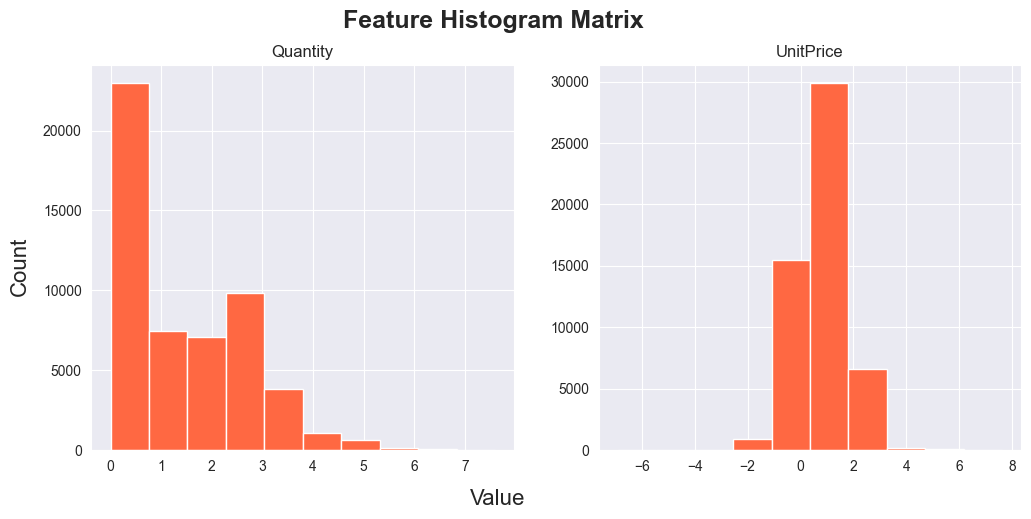

In [10]:
# Creating data frame for log values
log_data = data.copy()
log_data["Quantity"] = np.log(data["Quantity"])
log_data["UnitPrice"] = np.log(data["UnitPrice"])

# Creating histogram grid
log_data.hist(figsize=(12, 5), layout=(1, 2), color="#ff6842")
plt.subplots_adjust(hspace=0.1, wspace=0.2)
plt.suptitle("Feature Histogram Matrix", fontsize=18, fontweight="bold", y=0.99, x=0.46)
plt.text(-29.9, 15000, "Count", ha="left", va="center", rotation="vertical", fontsize=16)
plt.text(-12.5, -4000, "Value", ha="left", va="center", rotation="horizontal", fontsize=16);

### Plotting Feature Distribution

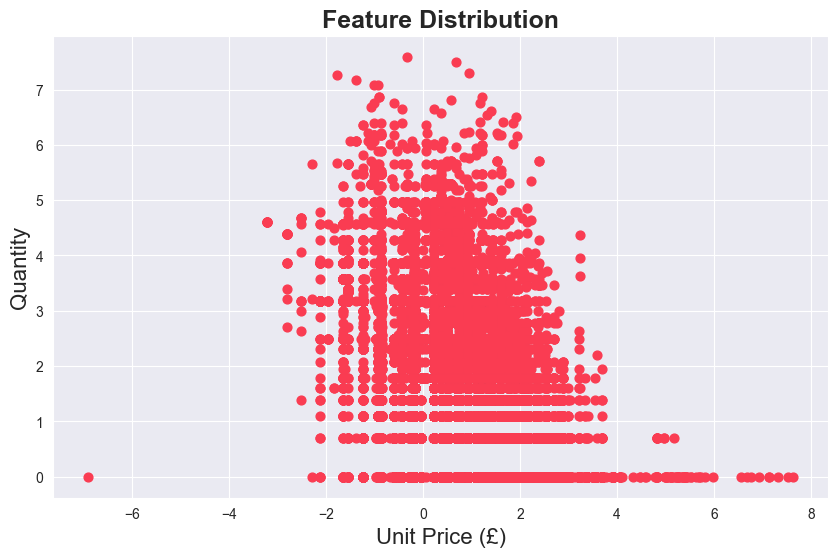

In [11]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.scatter(log_data['UnitPrice'], log_data["Quantity"], c='#fa3c52', s=40)
plt.xlabel("Unit Price (£)", fontsize = 16)
plt.ylabel("Quantity", fontsize = 16)
plt.title("Feature Distribution", fontsize = 18, fontweight="bold")
plt.show()

---
## Model Training
### K-Means Clustering
#### Elbow Method for Determining k

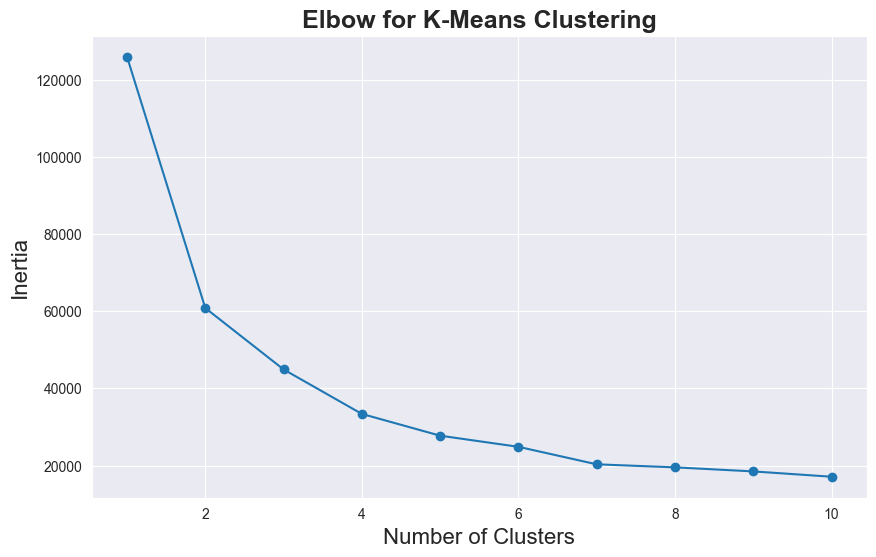

In [12]:
inertia = []
list_num_clusters = list(range(1,11))
for num_clusters in list_num_clusters:
    km = KMeans(n_clusters=num_clusters, random_state=8)
    km.fit(log_data)
    inertia.append(km.inertia_)

fig = plt.figure(figsize=(10,6))    
plt.plot(list_num_clusters,inertia)
plt.scatter(list_num_clusters,inertia)
plt.xlabel('Number of Clusters', fontsize=16)
plt.ylabel('Inertia', fontsize=16)
plt.title('Elbow for K-Means Clustering', fontsize=18, fontweight='bold');

Based on the visualization above, the optimal value of k is 2. We will create a `KMeans` object with `num_clusters = 2`

In [13]:
# Create K-Means object
num_clusters = 2
km = KMeans(n_clusters=num_clusters, random_state=8, n_init="auto").fit(log_data)

Now we plot the feature distribution with K-Means clusters

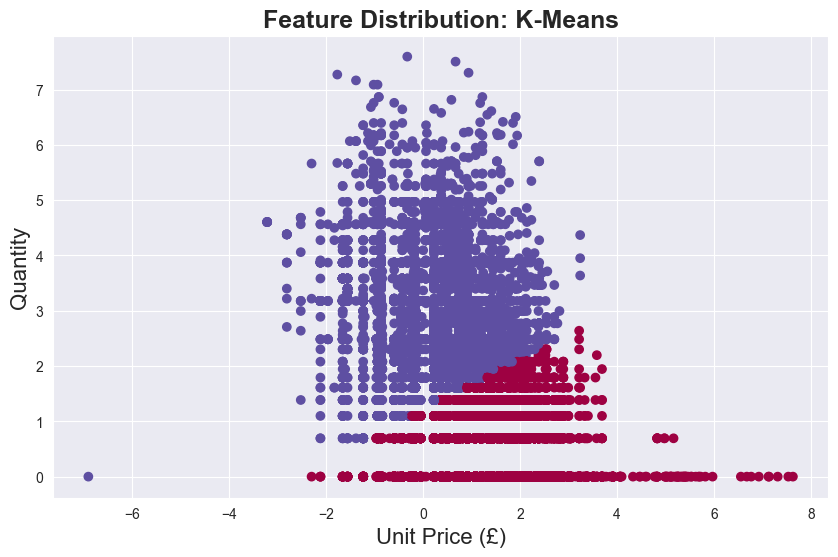

In [14]:
# Create scatter plot with KMeans clusters
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
plt.scatter(data=log_data, x='UnitPrice', y='Quantity', c=km.labels_, cmap='Spectral')
plt.xlabel("Unit Price (£)", fontsize = 16)
plt.ylabel("Quantity", fontsize = 16)
plt.title("Feature Distribution: K-Means", fontsize = 18, fontweight="bold");

In [15]:
# Calculate silhouette, Davies-Bouldin score
km_sil = silhouette_score(log_data, km.fit_predict(log_data))
km_db = davies_bouldin_score(log_data, km.fit_predict(log_data))

# Print scores
print(f"K-Means silhouette score: {km_sil}")
print(f"K-Means Davies-Bouldin score: {km_db}")

K-Means silhouette score: 0.45592637703609856
K-Means Davies-Bouldin score: 0.831467342686713


### DBSCAN Algorithm

We create a `DBSCAN` object and then plot the feature distribution again, but this time with the clusters prescribed by the `DBSCAN` function. 

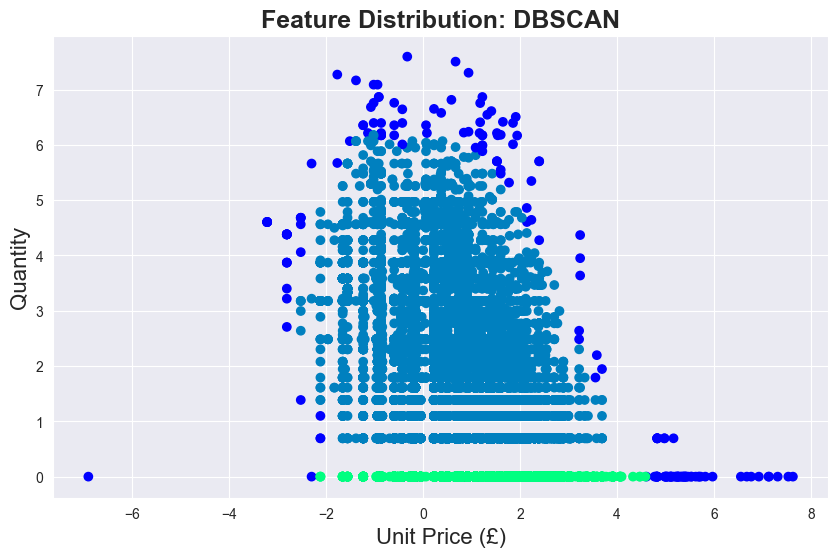

In [16]:
# Create DBSCAN object
db = DBSCAN(eps = 0.5, min_samples = 50).fit(log_data)

# Create scatter plot with DBSCAN clusters
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
plt.scatter(data=log_data, x='UnitPrice', y='Quantity', c=db.labels_, cmap='winter')
plt.xlabel("Unit Price (£)", fontsize = 16)
plt.ylabel("Quantity", fontsize = 16)
plt.title("Feature Distribution: DBSCAN", fontsize = 18, fontweight="bold");

In [17]:
# Calculate silhouette, Davies-Bouldin score
dbscan_sil = silhouette_score(log_data, db.fit_predict(log_data))
dbscan_db = davies_bouldin_score(log_data, db.fit_predict(log_data))

# Print scores
print(f"DBSCAN silhouette score: {dbscan_sil}")
print(f"DBSCAN Davies-Bouldin score: {dbscan_db}")

DBSCAN silhouette score: 0.31162785606585713
DBSCAN Davies-Bouldin score: 2.3700932252046063


### Agglomerative Clustering

Lastly, we create an `AgglomerativeClustering` object and then plot the feature distribution for the final time, this time with the clusters prescribed by the `AgglomerativeClustering` function. 

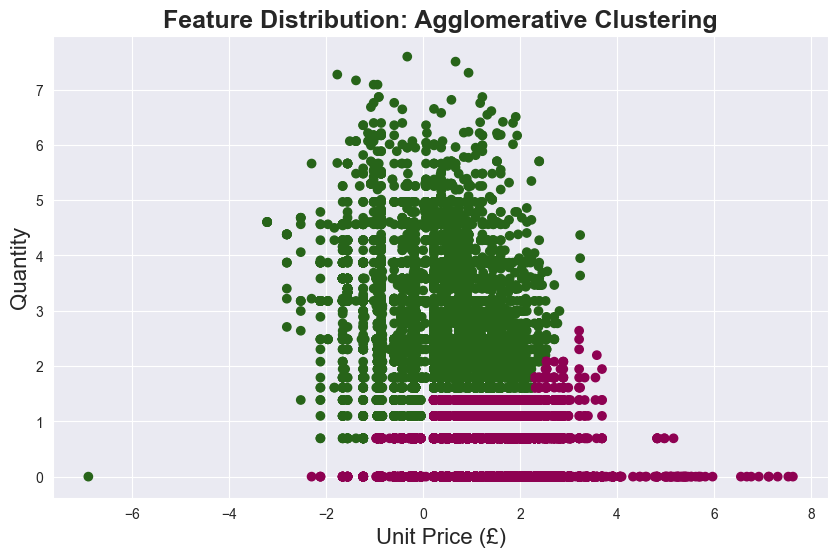

In [18]:
# Create AgglomerativeClustering object
ac = AgglomerativeClustering(compute_distances=True).fit(log_data)

# Create scatter plot with AgglomerativeClustering clusters
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
plt.scatter(data=log_data, x='UnitPrice', y='Quantity', c=ac.labels_, cmap='PiYG')
plt.xlabel("Unit Price (£)", fontsize = 16)
plt.ylabel("Quantity", fontsize = 16)
plt.title("Feature Distribution: Agglomerative Clustering", fontsize = 18, fontweight="bold");

We will also use a dendrogram to supplement the visualization above by showing the ward linkage behind the determination of the clusters. 

First, we create a helper function to plot the dendrogram:

In [19]:
# Define dendrogram plotting function
def plot_dendrogram(model, **kwargs):
    # Set color palette
    set_link_color_palette(['#8e0152','#276419'])
    # Create count of samples below each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1 
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count
    # Create linkage matrix
    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)
    # Plot the dendrogram
    fig = plt.figure(figsize=(10,6))
    dendrogram(linkage_matrix, **kwargs)

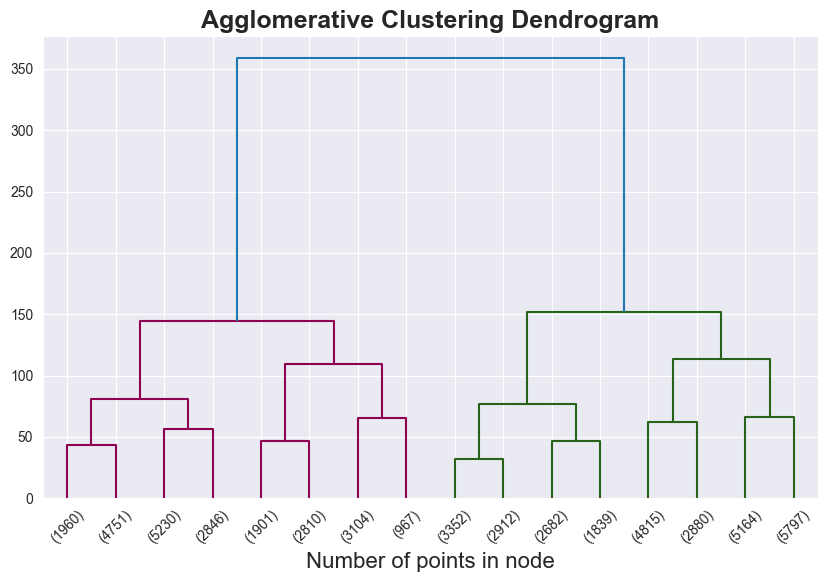

In [20]:
# Plot the top three levels of the dendrogram using our function
plot_dendrogram(ac, truncate_mode="level", p=3)
plt.title("Agglomerative Clustering Dendrogram", fontsize=18, fontweight='bold')
plt.xlabel("Number of points in node", fontsize=16)
plt.xticks(rotation=45, size=10)
plt.show()

In [21]:
# Calculate silhouette, Davies-Bouldin score
ac_sil = silhouette_score(log_data, ac.fit_predict(log_data))
ac_db = davies_bouldin_score(log_data, ac.fit_predict(log_data))

# Print scores
print(f"Agglomerative Clustering silhouette score: {ac_sil}")
print(f"Agglomerative Clustering Davies-Bouldin score: {ac_db}")

Agglomerative Clustering silhouette score: 0.4498864886274039
Agglomerative Clustering Davies-Bouldin score: 0.8438170572650372


---
## Algorithm Comparison

In [22]:
# Create score comparison dataframe
comp = pd.DataFrame({"Model Name":["K-Means", "DBSCAN", "Agglomerative Clustering"],
                     "Silhouette Score":[km_sil, dbscan_sil, ac_sil],
                     "Davies-Bouldin Score":[km_db, dbscan_db, ac_db]})

# Return dataframe
comp.sort_values(by="Davies-Bouldin Score")

,Model Name,Silhouette Score,Davies-Bouldin Score
0,K-Means,0.455926,0.831467
2,Agglomerative Clustering,0.449886,0.843817
1,DBSCAN,0.311628,2.370093


As shown in the table above, the K-Means algorithm has the greatest silhouette score, followed by Agglomerative Clustering and then DBSCAN algorithms. This suggests that the algorithm that produced the best clustering is the K-Means algorithm, as a higher value indicates better clustering (better separation and compactness). 

The opposite is true for the algorithms' Davies-Bouldin scores: the DBSCAN algorithm has the greatest Davies-Bouldin score, followed by Agglomerative Clustering and then K-Means algorithms. Just as with the silhouette score, the Davies-Bouldin scores suggest that the algorithm that produced the best clustering is the K-Means algorithm, as a lower value indicates better clustering. 

In summary, the scores above indicate that the ***K-Means algorithm is the best-suited*** for the task at hand. 

---
# Discussion
The K-Means algorithm is well-suited for the object of segmenting customers based on the consumer data metrics of quantity and unit price. In this application, the clusters are few in number and relatively similar in size. In combination with the flat geometry of our data, this suggests that the Agglomerative Clustering and DBSCAN algorithms would not be as suitable as the K-Means algorithm. This is supported by the silhouette scores and Davies-Bouldin scores, which further indicate that the K-Means algorithm produces the best results for our data.

The next step in the analysis of this data is to perform further hyperparameter tuning on our K-Means algorithm model to optimize its performance. We could also likely benefit from using a larger subset of the initial dataset, or even the entire dataset; however, this would be much more resource-intensive and would take a long time to execute. 